<a href="https://colab.research.google.com/github/nicholascarrick/Neural-Network-Projects/blob/main/MilestoneProject2_Skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

Build an NLP model to make reading medical abstracts easier 


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from sklearn import metrics
 

In [2]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

def evaluate_model(y_true,y_pred):
  metrics_dict = {}

  accuracy = round((accuracy_score(y_true,y_pred))*100,2)
  metrics_dict["accuracy"] = str(accuracy) + "%"

  precision = round((precision_score(y_true,y_pred,average="macro"))*100,2)
  metrics_dict["precision"] = str(precision) + "%"

  recall = round((recall_score(y_true,y_pred,average="macro"))*100,2)
  metrics_dict["recall"] = str(recall) + "%"

  f1 = round((f1_score(y_true,y_pred,average="macro"))*100,2)
  metrics_dict["f1_score"] = str(f1) + "%"

  confuse = confusion_matrix(y_true,y_pred)

  return metrics_dict , confuse


In [3]:
#download the dataset from the author's github
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.


In [4]:
#load in train and test data
train = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"
val = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt"
test = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt"

In [5]:
#preprocess Data
#Write a python script to read the lines of a doc
train_file = open(train).readlines()
val_file = open(val).readlines()
test_file = open(test).readlines()

In [6]:
train_file

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
def preprocessText(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = filename # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [8]:
train_data = preprocessText(train_file)
test_data = preprocessText(test_file)
val_data = preprocessText(val_file)


In [9]:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [10]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

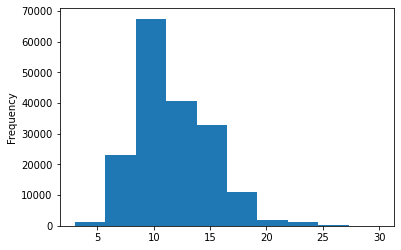

In [11]:
train_df.total_lines.plot.hist()

#Get Lists of Sentences

In [12]:
#convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
test_sentences = test_df["text"].to_list()
val_sentences = val_df["text"].to_list()


In [13]:
len(train_sentences),len(test_sentences),len(val_sentences)

(180040, 30135, 30212)

In [14]:
from sklearn.preprocessing import  OneHotEncoder
hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))

In [15]:
val_labels_one_hot = hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [16]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())


In [17]:
test_labels_encoded

array([0, 4, 4, ..., 4, 4, 1])

# Starting a series of modeling Experiments

## Model 0: Getting Baseline
TF-IDF Multinomial Naive Bayes Classifer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create a pipeline
model_0 = Pipeline([
  ("tf-idf",TfidfVectorizer()),
  ("cif",MultinomialNB())
])

#fit pipeline to training data
model_0.fit(
    X = train_sentences,
    y = train_labels_encoded
)

y_pred = model_0.predict(test_sentences)

In [19]:
y_pred

array([2, 2, 2, ..., 4, 4, 4])

In [20]:
baseline_evaluations= evaluate_model(test_labels_encoded,y_pred)

In [21]:
baseline_evaluations

({'accuracy': '71.67%',
  'f1_score': '59.13%',
  'precision': '69.94%',
  'recall': '58.02%'},
 array([[1688,  859,  759,   88,  227],
        [ 278, 2642,  391,    7, 1253],
        [ 103,   77, 8683,    7, 1027],
        [ 520,  420,  968,  294,  131],
        [  19,  186, 1215,    3, 8290]]))

##Preparing our data for deep sequence models
Before we start building models, we need to create vectorization and embedding layers

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [23]:
#how long is each sentences on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

In [24]:
#how long of a sentence covers 95% of sentences 
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [25]:
##Vetorization Layer
text_vectorizor = layers.experimental.preprocessing.TextVectorization(
    max_tokens = 68000,output_sequence_length=55)

In [26]:
text_vectorizor.adapt(train_sentences)

In [27]:
text_vectorizor.get_vocabulary()[-10:]

['aarm',
 'aaqol',
 'aaq',
 'aanhui',
 'aana',
 'aainduced',
 'aaigroup',
 'aachener',
 'aachen',
 'aaacp']

In [28]:
##Create custom embedding layer

In [29]:
embed = layers.Embedding(
    input_dim = 68000,
    output_dim = 128,
    input_length = 55,
    mask_zero=True
)

##Creating datasets
tf.data API can be used to make prefetched datasets


In [30]:
#Turn our data into TF datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [31]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [32]:
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizor(inputs)
x = embed(x)
x = layers.Conv1D(64,3,activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_1 = tf.keras.Model(inputs,outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 53, 64)            24640     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [33]:
model_1.compile(
    loss= tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [34]:
model_1_history = model_1.fit(
    train_dataset,
    steps_per_epoch = int(.1*len(train_dataset)),
    epochs = 5,
    validation_data = valid_dataset,
    validation_steps = len(valid_dataset)
)

Epoch 1/5
562/562 [==============================] - 19s 18ms/step - loss: 0.9559 - accuracy: 0.6207 - val_loss: 0.7086 - val_accuracy: 0.7288
Epoch 2/5
562/562 [==============================] - 10s 18ms/step - loss: 0.6742 - accuracy: 0.7453 - val_loss: 0.6505 - val_accuracy: 0.7631
Epoch 3/5
562/562 [==============================] - 10s 18ms/step - loss: 0.6342 - accuracy: 0.7637 - val_loss: 0.6184 - val_accuracy: 0.7768
Epoch 4/5
562/562 [==============================] - 10s 18ms/step - loss: 0.6080 - accuracy: 0.7778 - val_loss: 0.5968 - val_accuracy: 0.7788
Epoch 5/5
562/562 [==============================] - 10s 18ms/step - loss: 0.6067 - accuracy: 0.7845 - val_loss: 0.5794 - val_accuracy: 0.7928


In [35]:
model_1_preds = model_1.predict(test_dataset)

In [36]:
model_1_preds = tf.argmax(model_1_preds,axis=1)
model_1_evaluations = evaluate_model(test_labels_encoded,model_1_preds)

In [37]:
model_1_evaluations

({'accuracy': '78.6%',
  'f1_score': '71.22%',
  'precision': '73.49%',
  'recall': '70.18%'},
 array([[2304,  557,  333,  383,   44],
        [ 590, 3112,  180,   22,  667],
        [ 113,  115, 9101,   76,  492],
        [ 865,  207,  226, 1008,   27],
        [  38,  387, 1124,    4, 8160]]))

#Model 2 : NLP with Transfer Learning

In [38]:
import tensorflow_hub as hub
use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")

In [39]:
inputs = layers.Input(shape= [],dtype="string")
x = use(inputs)
x = layers.Dense(128,activation = "relu")(x)
outputs = layers.Dense(5 , activation="softmax")(x)
model_2 = tf.keras.Model(inputs,outputs)

model_2.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.categorical_crossentropy,
    metrics = ["accuracy"]
)
model_2_history = model_2.fit(
    train_dataset,
    steps_per_epoch = int(.1*len(train_dataset)),
    epochs = 5,
    validation_data = valid_dataset
)

Epoch 1/5
562/562 [==============================] - 26s 41ms/step - loss: 0.9142 - accuracy: 0.6487 - val_loss: 0.7999 - val_accuracy: 0.6930
Epoch 2/5
562/562 [==============================] - 23s 40ms/step - loss: 0.7688 - accuracy: 0.7020 - val_loss: 0.7558 - val_accuracy: 0.7097
Epoch 3/5
562/562 [==============================] - 23s 41ms/step - loss: 0.7519 - accuracy: 0.7132 - val_loss: 0.7399 - val_accuracy: 0.7152
Epoch 4/5
562/562 [==============================] - 23s 40ms/step - loss: 0.7193 - accuracy: 0.7265 - val_loss: 0.7151 - val_accuracy: 0.7289
Epoch 5/5
562/562 [==============================] - 23s 41ms/step - loss: 0.7271 - accuracy: 0.7209 - val_loss: 0.6992 - val_accuracy: 0.7346


In [40]:
model_2_preds = model_2.predict(test_dataset)
model_2_preds = tf.argmax(model_2_preds,axis=1)

In [41]:
model_2_evaluations = evaluate_model(test_labels_encoded,model_2_preds)

In [42]:
model_2_evaluations

({'accuracy': '72.81%',
  'f1_score': '66.2%',
  'precision': '68.56%',
  'recall': '64.81%'},
 array([[1965,  697,  466,  355,  138],
        [ 614, 2688,  406,   83,  780],
        [ 197,  176, 8679,  105,  740],
        [ 541,  292,  360, 1064,   76],
        [  68,  380, 1694,   26, 7545]]))

##Model 3 : Conv1D with Character Embeddings

In [43]:
###Create a character level tokenizer
train_sentences[:5
]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [44]:
def split_chars(text):
  return " ".join(list(text))

In [45]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [46]:
train_char = [split_chars(sentence) for sentence in train_sentences]
val_char = [split_chars(sentence) for sentence in val_sentences]
test_char = [split_chars(sentence) for sentence in test_sentences]

In [47]:
#what is the average character length?
char_lenghts = [len(sentence) for sentence in train_sentences]
mean_lenghts = np.mean(char_lenghts)
mean_lenghts

149.3662574983337

In [48]:
#Find char legnth covers 95% of sequences
int(np.percentile(char_lenghts,95))

290

In [49]:
#get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [50]:
#Create the text vectorizor layer
text_vectorizor = layers.TextVectorization(
    max_tokens = (len(alphabet)+2),
    output_sequence_length = 290)

In [51]:
text_vectorizor.adapt(train_char)

In [52]:
text_vectorizor.get_vocabulary()[:5]

['', '[UNK]', 'e', 't', 'i']

In [53]:
char_embed = tf.keras.layers.Embedding(len(alphabet)+2,25,mask_zero=True)

In [54]:
char_embed(text_vectorizor(train_char[0]))

<tf.Tensor: shape=(290, 25), dtype=float32, numpy=
array([[-0.01146435,  0.02483621,  0.04747908, ...,  0.02988071,
         0.00094678,  0.01613695],
       [-0.02017597, -0.0383004 , -0.03267059, ..., -0.01731143,
         0.00093906,  0.03365372],
       [ 0.01253552, -0.0363033 , -0.03495401, ..., -0.00022874,
        -0.00539745, -0.02454642],
       ...,
       [-0.01476667, -0.04741892, -0.04689318, ..., -0.03789715,
         0.02433336,  0.0152959 ],
       [-0.01476667, -0.04741892, -0.04689318, ..., -0.03789715,
         0.02433336,  0.0152959 ],
       [-0.01476667, -0.04741892, -0.04689318, ..., -0.03789715,
         0.02433336,  0.0152959 ]], dtype=float32)>

In [55]:
#Create char level datasets
train_char_ds = tf.data.Dataset.from_tensor_slices((train_char,train_labels_one_hot))
val_char_ds = tf.data.Dataset.from_tensor_slices((val_char,val_labels_one_hot))
test_char_ds = tf.data.Dataset.from_tensor_slices((test_char,test_labels_one_hot))

In [56]:
train_char_ds = train_char_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_ds = val_char_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_ds = test_char_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizor(inputs)
x = char_embed(x)
x = layers.Bidirectional(layers.LSTM(128,))(x)
outputs = layers.Dense(5,activation="softmax")(x)
model_3 = tf.keras.Model(inputs,outputs)
model_3.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.categorical_crossentropy,
    metrics = ['accuracy']
)
model_3_history = model_3.fit(
    train_char_ds,
    epochs = 5,
    steps_per_epoch=int(.1*len(train_char_ds)),
    validation_data = val_char_ds
)

Epoch 1/5
562/562 [==============================] - 131s 217ms/step - loss: 1.3539 - accuracy: 0.4283 - val_loss: 1.2465 - val_accuracy: 0.4786
Epoch 2/5
562/562 [==============================] - 119s 211ms/step - loss: 1.2166 - accuracy: 0.4908 - val_loss: 1.1595 - val_accuracy: 0.5224
Epoch 3/5
562/562 [==============================] - 115s 204ms/step - loss: 1.1571 - accuracy: 0.5228 - val_loss: 1.1122 - val_accuracy: 0.5389
Epoch 4/5
562/562 [==============================] - 119s 212ms/step - loss: 1.0899 - accuracy: 0.5542 - val_loss: 1.0593 - val_accuracy: 0.5617
Epoch 5/5
562/562 [==============================] - 114s 204ms/step - loss: 1.0645 - accuracy: 0.5599 - val_loss: 1.0455 - val_accuracy: 0.5695


In [58]:
#Make predictions with character embed model
model_3_preds = model_3.predict(test_char_ds)
model_3_preds = tf.argmax(model_3_preds,axis=1)

In [59]:
model_3_evaluations = evaluate_model(test_labels_encoded,model_3_preds)

In [60]:
model_3_evaluations

({'accuracy': '56.6%',
  'f1_score': '51.34%',
  'precision': '55.25%',
  'recall': '50.1%'},
 array([[1177,  968,  917,  326,  233],
        [ 739, 1788, 1407,   80,  557],
        [ 404,  552, 8055,   75,  811],
        [ 403,  337,  410, 1085,   98],
        [ 332,  847, 3535,   48, 4951]]))

#Model 4 : Combining pretrained token embed + char emed

1. create a token-level embedding
2. create a char-level embedding
3. combine 1&2 with a concatenate laeyer
4. build output layers
5. Build output layer that takes the two inputs


In [61]:
#1. Setup token inputs/model
token_inputs = layers.Input(shape=[],dtype="string",name="token_input")
token_embeddings = use(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs,token_outputs)

#2. Setup a char inputs/model
char_inputs = layers.Input(shape=(1,),dtype="string",name="char_input")
char_vectors = text_vectorizor(char_inputs)
char_embeddings = char_embed(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, outputs = char_outputs)

#3. Concatenate token and char inputs
token_char_concat = layers.Concatenate()([token_model.output,char_model.output])

#4. Create output layers - adding in dropout layers
combined_dropout = layers.Dropout(.5)(token_char_concat)
combined_dense = layers.Dense(128,activation="relu")(combined_dropout)
second_dropout = layers.Dropout(.5)(combined_dense)
output_layer = layers.Dense(5,activation="softmax")(second_dropout)

#5 Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs = output_layer)

model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_input[0][0]']      

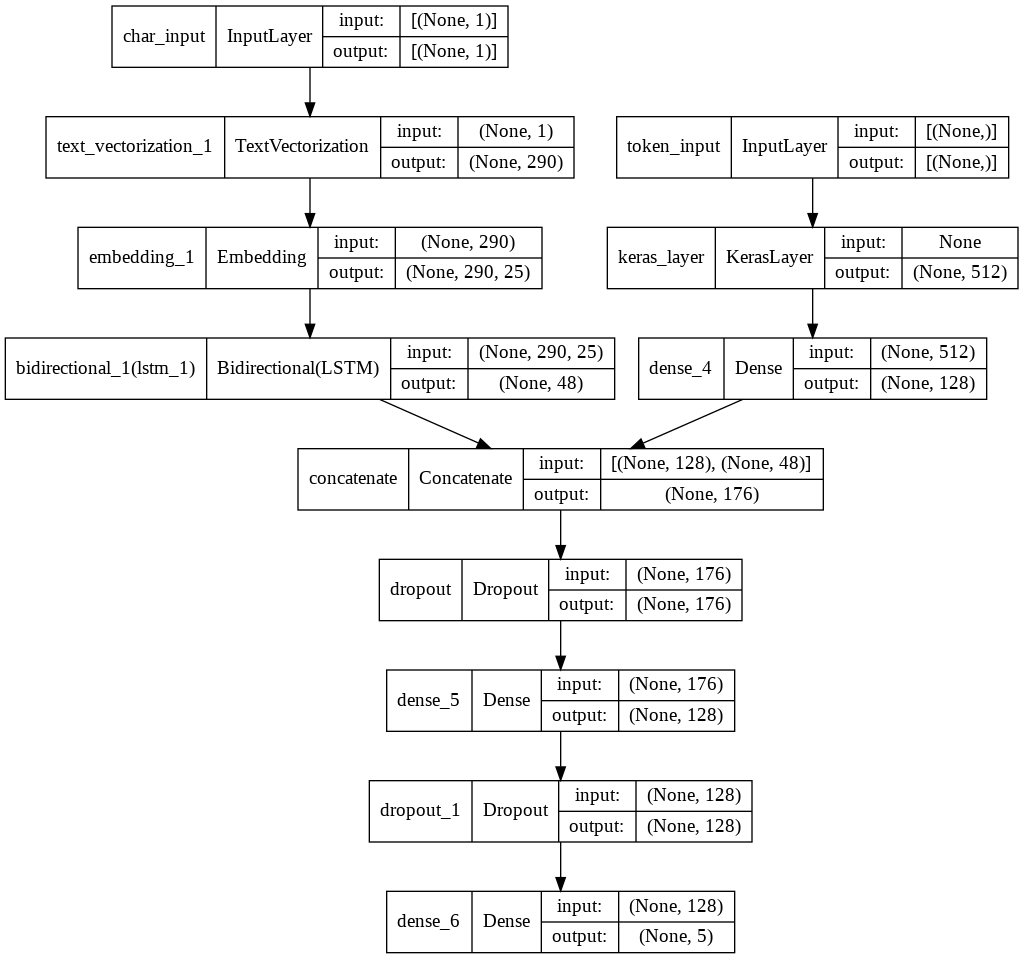

In [62]:
#plot model
tf.keras.utils.plot_model(model_4,show_shapes=True)

In [63]:
model_4.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.categorical_crossentropy,
    metrics = ["accuracy"]
)

In [64]:
#Create datasets using tf.data api
token_char_train = tf.data.Dataset.from_tensor_slices((train_sentences,train_char))
token_char_train_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_mixed_ds = tf.data.Dataset.zip((token_char_train,token_char_train_labels))

train_mixed_ds = train_mixed_ds.batch(32).prefetch(tf.data.AUTOTUNE)

token_char_val = tf.data.Dataset.from_tensor_slices((val_sentences,val_char))
token_char_val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_mixed_ds = tf.data.Dataset.zip((token_char_val,token_char_val_labels))

val_mixed_ds = val_mixed_ds.batch(32).prefetch(tf.data.AUTOTUNE)

token_char_test = tf.data.Dataset.from_tensor_slices((test_sentences,test_char))
token_char_test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_mixed_ds = tf.data.Dataset.zip((token_char_test,token_char_test_labels))

test_mixed_ds = test_mixed_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [65]:
model_4_history = model_4.fit(
   train_mixed_ds,
   epochs = 5,
   steps_per_epoch = int(.1*len(train_mixed_ds)),
   validation_data = val_mixed_ds
)

Epoch 1/5
562/562 [==============================] - 123s 201ms/step - loss: 0.9852 - accuracy: 0.6055 - val_loss: 0.7860 - val_accuracy: 0.7013
Epoch 2/5
562/562 [==============================] - 110s 196ms/step - loss: 0.7980 - accuracy: 0.6926 - val_loss: 0.7196 - val_accuracy: 0.7279
Epoch 3/5
562/562 [==============================] - 106s 189ms/step - loss: 0.7779 - accuracy: 0.7039 - val_loss: 0.6958 - val_accuracy: 0.7350
Epoch 4/5
562/562 [==============================] - 112s 200ms/step - loss: 0.7396 - accuracy: 0.7184 - val_loss: 0.6726 - val_accuracy: 0.7449
Epoch 5/5
562/562 [==============================] - 109s 193ms/step - loss: 0.7486 - accuracy: 0.7165 - val_loss: 0.6620 - val_accuracy: 0.7484


In [66]:
model_4_preds = model_4.predict(test_mixed_ds)

In [70]:
model_4_pred = tf.argmax(model_4_preds,axis=1)

In [72]:
model_4_evaluations = evaluate_model(test_labels_encoded,model_4_pred)

In [73]:
model_4_evaluations

({'accuracy': '74.15%',
  'f1_score': '67.69%',
  'precision': '70.09%',
  'recall': '66.16%'},
 array([[1890,  771,  418,  388,  154],
        [ 550, 2685,  342,   48,  946],
        [ 191,  166, 8774,   61,  705],
        [ 528,  273,  277, 1184,   71],
        [  59,  286, 1533,   22, 7813]]))

# Model 5 : Pretrained Embedding + Char Embedding + Positional Embedding

In [74]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


###Create positional embeddings

In [76]:
#how many line numbers are there
train_df.line_number.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [80]:
#Use tf to create on-hot-encoded tensors of our line-number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth=15)

In [100]:
train_line_numbers_one_hot.dtype

tf.float32

In [87]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

In [89]:
len(train_total_lines_one_hot),len(train_line_numbers_one_hot)

(180040, 180040)

### Building a tribrid embedding model
1. token-level model
2. char level model 
3. line number model
4. total lines feature
5. combine outputs of 1/2 using Concatenate
6. combine outputs of 3/4/5 using concat
7. create output layer
8. combine inputs of 1,2,3,4 and outputs into a model

In [103]:
#1. token-level
token_inputs = layers.Input(shape=[],dtype="string")
x = use(token_inputs)
token_outputs = layers.Dense(128,activation = "relu")(x)
token_model = tf.keras.Model(token_inputs,token_outputs)

#2. char-level
char_inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizor(char_inputs)
x = char_embed(x)
bilstm = layers.Bidirectional(layers.LSTM(24))(x)
char_model = tf.keras.Model(char_inputs,bilstm)

#3. line number model
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32)
line_number_outputs = layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs,line_number_outputs)

#4. Total lines model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32)
total_lines_outputs = layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs,total_lines_outputs)

#5. Concat 1/2
concat_token_char = layers.Concatenate()([token_model.output,char_model.output])

z = layers.Dense(256,activation="relu")(concat_token_char)
z = layers.Dropout(.5)(z)

#6 Concat 3/4/5
concat_concatted_linenum_totalline = layers.Concatenate()([line_number_model.output,
                                                           total_lines_model.output,
                                                           z])

#7. Output layer

output_layer = layers.Dense(5,activation = "softmax")(concat_concatted_linenum_totalline)

#8. Create overall model for all inputs 
model_5 = tf.keras.Model(inputs =[token_model.inputs,
                                  char_model.inputs,
                                  line_number_model.inputs,
                                  total_lines_model.inputs],
                         outputs = output_layer)

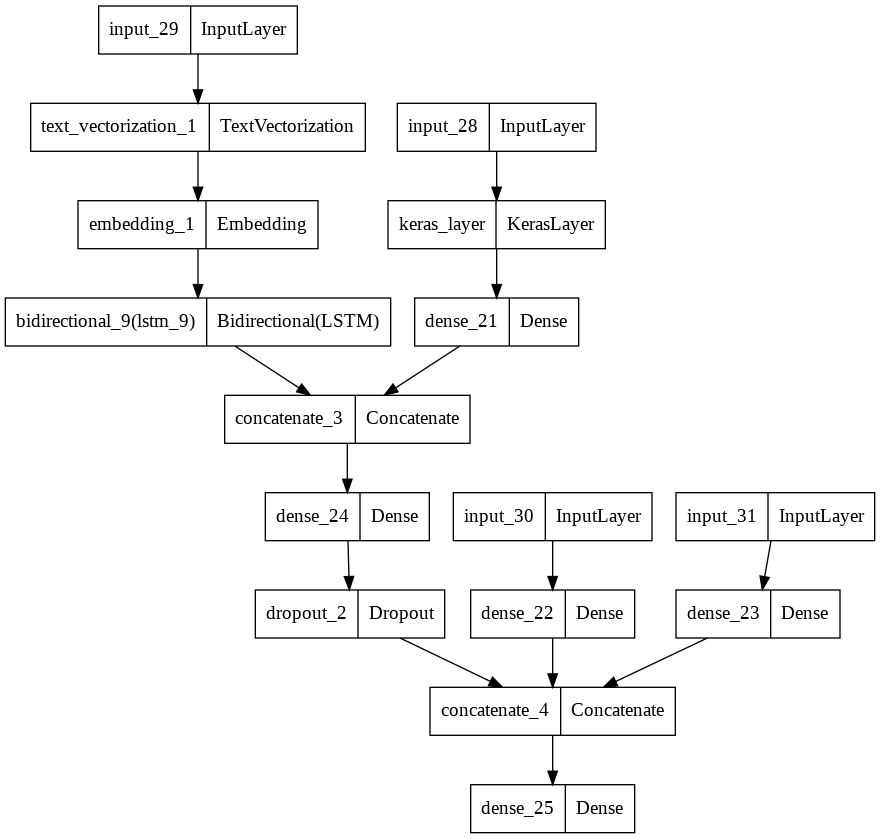

In [107]:
tf.keras.utils.plot_model(model_5)

##Create training, validation, and test sets for all inputs

In [109]:
complete_train = tf.data.Dataset.from_tensor_slices((train_sentences,train_char,train_line_numbers_one_hot,train_total_lines_one_hot))
complete_train_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
complete_train_ds = tf.data.Dataset.zip((complete_train,complete_train_labels))

complete_train_ds = complete_train_ds.batch(32).prefetch(tf.data.AUTOTUNE)

complete_val = tf.data.Dataset.from_tensor_slices((val_sentences,val_char,val_line_numbers_one_hot,val_total_lines_one_hot))
complete_val_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
complete_val_ds = tf.data.Dataset.zip((complete_val,complete_val_labels))

complete_val_ds = complete_val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

complete_test = tf.data.Dataset.from_tensor_slices((test_sentences,test_char,test_line_numbers_one_hot,test_total_lines_one_hot))
complete_test_labels = tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
complete_test_ds = tf.data.Dataset.zip((complete_test,complete_test_labels))

complete_test_ds = complete_test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [110]:
model_5.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss= tf.keras.losses.categorical_crossentropy,
    metrics = ['accuracy']
)

In [112]:
model_5_history = model_5.fit(
    complete_train_ds,
    steps_per_epoch = int(.1*len(complete_train_ds)),
    epochs = 5,
    validation_data= complete_val_ds,
    validation_steps = int(.1*len(complete_val_ds))
)

Epoch 1/5
562/562 [==============================] - 85s 132ms/step - loss: 0.7529 - accuracy: 0.7173 - val_loss: 0.5420 - val_accuracy: 0.8009
Epoch 2/5
562/562 [==============================] - 72s 127ms/step - loss: 0.4997 - accuracy: 0.8117 - val_loss: 0.4649 - val_accuracy: 0.8268
Epoch 3/5
562/562 [==============================] - 68s 121ms/step - loss: 0.4639 - accuracy: 0.8208 - val_loss: 0.4436 - val_accuracy: 0.8261
Epoch 4/5
562/562 [==============================] - 73s 129ms/step - loss: 0.4450 - accuracy: 0.8350 - val_loss: 0.4225 - val_accuracy: 0.8404
Epoch 5/5
562/562 [==============================] - 69s 123ms/step - loss: 0.4303 - accuracy: 0.8349 - val_loss: 0.4120 - val_accuracy: 0.8378


In [115]:
model_5_preds = model_5.predict(complete_test_ds)
model_5_preds =tf.argmax(model_5_preds,axis=1)

In [116]:
model_5_evaluations = evaluate_model(test_labels_encoded,model_5_preds)

In [117]:
model_5_evaluations

({'accuracy': '83.77%',
  'f1_score': '78.8%',
  'precision': '82.72%',
  'recall': '77.45%'},
 array([[3002,   27,  373,  205,   14],
        [  85, 3666,  106,    0,  714],
        [ 124,   98, 9223,   16,  436],
        [1064,    0,  201, 1064,    4],
        [  17,  309, 1096,    1, 8290]]))